# Fork Migration

This notebook demonstrates the workload behaviour when new task is forked

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [3]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [4]:
# Setup a target configuration
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

            
    # List of additional devlib modules to install 
    "modules" : ['cgroups', 'bl', 'cpufreq'],

    # Account to access the remote target
    "host"        : '10.169.38.40',
    "username"    : 'root',
    "password"    : '',


}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "fork_migration",
}

In [5]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

03:46:32  INFO    : Using base path: /home/lisa/lisa-github
03:46:32  INFO    : Loading custom (inline) target configuration
03:46:32  INFO    : Loading custom (inline) test configuration
03:46:32  INFO    : External tools using:
03:46:32  INFO    :    ANDROID_HOME: /home/lisa/android-sdk
03:46:32  INFO    :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
03:46:32  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups']
03:46:32  INFO    : Connecting Android target [0123456789ABCDEF]
03:46:32  INFO    : Connection settings:
03:46:32  INFO    :    {'device': '0123456789ABCDEF'}
03:46:33  INFO    : Initializing target workdir:
03:46:33  INFO    :    /data/local/tmp/devlib-target
03:46:33  INFO    : Available controllers:
03:46:34  INFO    :   cpuset       : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
03:46:34  INFO    :   cpu          : /data/local/tmp/devlib-target/cgroups/devlib_cgh4
03:46:34  INFO    :   cpuacct      : /data/local/tmp/devlib-target/cgro

# Workload configuration

In [6]:
# Set Sched governor
#
# For Juno big/LITTLE CPUs
#
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

target.cpufreq.set_all_governors('sched')

logging.info("Target current governor: %s",
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")
            )
logging.info("Target big CPU max CPUfreq:%s\n\t\t    Target big CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu4/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu4/cpufreq/scaling_cur_freq")
             )

logging.info("Target LITTLE CPU max CPUfreq:%s \n\t\t    Target LITTLE CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq")
             )

03:46:39  INFO    : Target ABI: arm64, CPus: ['A53', 'A53', 'A53', 'A53', 'A73', 'A73', 'A73', 'A73']
03:46:39  INFO    : Target current governor: sched
03:46:39  INFO    : Target big CPU max CPUfreq:2362000
		    Target big CPU current CPUfreq: 1805000
03:46:39  INFO    : Target LITTLE CPU max CPUfreq:1844000 
		    Target LITTLE CPU current CPUfreq: 1844000


In [30]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        "early_starter_1" : Periodic(
            period_ms=10,
            duty_cycle_pct=60,
            duration_s=5,
        ).get(),

        "early_starter_2" : Periodic(
            period_ms=10,
            duty_cycle_pct=60,
            duration_s=5,
        ).get(),

        
        "delay_starter_1" : Periodic(
            period_ms=10,
            duty_cycle_pct=60,
            duration_s=5,
            delay_s=1,
        ).get(),
        
        "delay_starter_2" : Periodic(
            period_ms=10,
            duty_cycle_pct=60,
            duration_s=5,
            delay_s=1,
        ).get(),

#        "delay_starter_3" : Periodic(
#            period_ms=10,
#            duty_cycle_pct=100,
#            duration_s=5,
#            delay_s=2,
#        ).get(),
#        
#        "delay_starter_4" : Periodic(
#            period_ms=10,
#            duty_cycle_pct=100,
#            duration_s=5,
#            delay_s=2,
#        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

04:48:18  INFO    : Setup new workload simple
04:48:18  INFO    : Workload duration defined by longest task
04:48:18  INFO    : Default policy: SCHED_OTHER
04:48:18  INFO    : ------------------------
04:48:18  INFO    : task [delay_starter_1], sched: using default policy
04:48:18  INFO    :  | start delay: 1.000000 [s]
04:48:18  INFO    :  | loops count: 1
04:48:18  INFO    : + phase_000001: duration 5.000000 [s] (500 loops)
04:48:18  INFO    : |  period    10000 [us], duty_cycle  60 %
04:48:18  INFO    : |  run_time   6000 [us], sleep_time   4000 [us]
04:48:18  INFO    : ------------------------
04:48:18  INFO    : task [delay_starter_2], sched: using default policy
04:48:18  INFO    :  | start delay: 1.000000 [s]
04:48:18  INFO    :  | loops count: 1
04:48:18  INFO    : + phase_000001: duration 5.000000 [s] (500 loops)
04:48:18  INFO    : |  period    10000 [us], duty_cycle  60 %
04:48:18  INFO    : |  run_time   6000 [us], sleep_time   4000 [us]
04:48:18  INFO    : ----------------

# Workload execution

In [31]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

04:48:20  INFO    : #### Setup FTrace
04:48:23  INFO    : #### Start energy sampling


04:48:24  INFO    : #### Start RTApp execution
04:48:24  INFO    : Workload execution START:
04:48:24  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
04:48:30  INFO    : #### Read energy consumption: /home/lisa/lisa-github/results/fork_migration/energy.json
04:48:34  INFO    : #### Stop FTrace
04:48:34  INFO    : #### Save FTrace: /home/lisa/lisa-github/results/fork_migration/trace.dat
04:48:36  INFO    : #### Save platform description: /home/lisa/lisa-github/results/fork_migration/platform.json


# Collected results

In [32]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

04:48:39  INFO    : Content of the output folder /home/lisa/lisa-github/results/fork_migration


total 37536
drwxrwxr-x 1 lisa lisa      730 Aug 25 04:48 .
drwxrwxr-x 1 lisa lisa     1364 Aug 25 03:46 ..
drwxrwxr-x 1 lisa lisa      740 Aug 25 04:46 .trace.txt.cache
-rw-rw-r-- 1 lisa lisa       47 Aug 25 04:48 energy.json
-rw-rw-r-- 1 lisa lisa      383 Aug 25 04:48 energy_stats.json
-rw-rw-r-- 1 lisa lisa      581 Aug 25 04:48 output.log
-rw-rw-r-- 1 lisa lisa     1519 Aug 25 04:48 platform.json
-rw-r--r-- 1 lisa lisa    62160 Aug 25 04:48 rt-app-delay_starter_1-0.log
-rw-r--r-- 1 lisa lisa    62160 Aug 25 04:48 rt-app-delay_starter_2-1.log
-rw-r--r-- 1 lisa lisa    62160 Aug 25 04:48 rt-app-early_starter_1-2.log
-rw-r--r-- 1 lisa lisa    62160 Aug 25 04:48 rt-app-early_starter_2-3.log
-rw-rw-r-- 1 lisa lisa    31260 Aug 25 04:48 samples_Device0.csv
-rw-rw-r-- 1 lisa lisa    33088 Aug 25 04:48 samples_Device1.csv
-rw-r--r-- 1 lisa lisa     1825 Aug 25 04:48 simple_00.json
-rw-rw-r-- 1 lisa lisa    80478 Aug 25 04:46 task_perf_delay_starter_1.png
-rw-rw-r-- 1 lisa lisa    77105 Aug

In [33]:
!cat {te.res_dir}/rt-app-delay_starter_1-0.log

# Policy : SCHED_OTHER priority : 0
#idx     perf      run   period           start             end          rel_st      slack c_duration   c_period     wu_lat
   0    44117    35420    35426     11793482959     11793518385         1004572     -26281       6000      10000          0
   0    44117    14008    14010     11793518401     11793532411         1040014      -4025       6000      10000          0
   0    44117     6136    10307     11793532417     11793542724         1054030       3858       6000      10000        313
   0    44117     6142     9969     11793542728     11793552697         1064341       3540       6000      10000        286
   0    44117     6134    10037     11793552701     11793562738         1074314       3575       6000      10000        327
   0    44117     6141     9977     11793562742     11793572719         1084355       3528       6000      10000        307
   0    44117     6135    10012     11793572723     11793582735         1094336       3552      

In [34]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

04:48:51  INFO    : Generated RTApp JSON file:


In [35]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels , indent=4, sort_keys=True)

04:48:52  INFO    : Energy: /home/lisa/lisa-github/results/fork_migration/energy.json


{
    "Device0": 0.0, 
    "Device1": 27018.2
}


In [36]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

04:48:54  INFO    : Platform description: /home/lisa/lisa-github/results/fork_migration/platform.json


# Trace inspection

In [37]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# New Task Behavior

In [15]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['early_starter_1', "early_starter_2", "delay_starter_1",
                                             "delay_starter_2", "delay_starter_3", "delay_starter_4",
                                            ])

/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.set_next_entity object at 0x7f782efdf450> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f782efdf550> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_move_numa object at 0x7f782efdf650> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_wait_task object at 0x7f782efdf750> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_stat_blocked object at 0x7f782efdf950> from c

# RTApp task performance plots

04:49:42  INFO    : PerfIndex, Task [delay_starter_2] avg: 0.70, std: 0.36
04:49:44  INFO    : PerfIndex, Task [delay_starter_1] avg: 0.69, std: 0.37
04:49:45  INFO    : PerfIndex, Task [early_starter_1] avg: 0.68, std: 0.23
04:49:46  INFO    : PerfIndex, Task [early_starter_2] avg: 0.70, std: 0.22


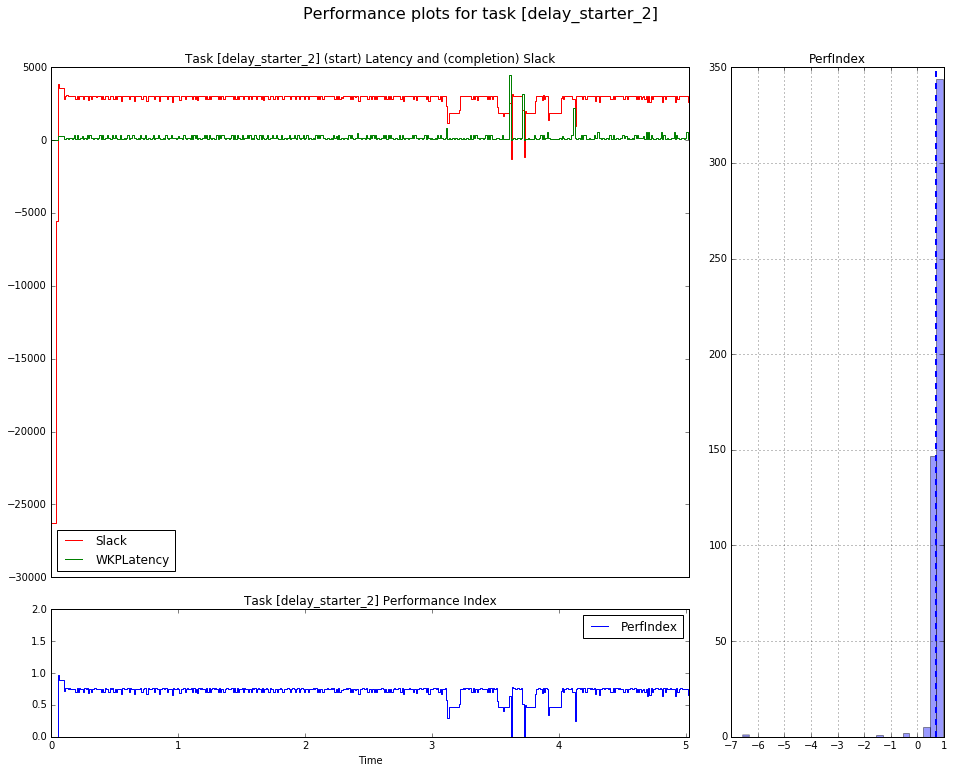

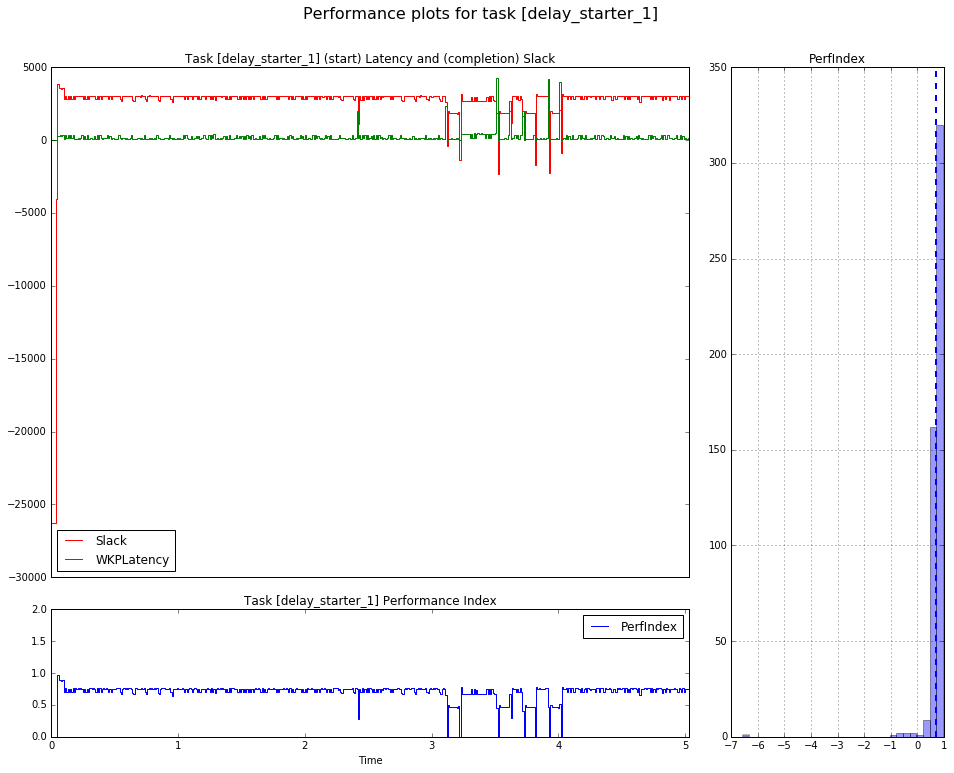

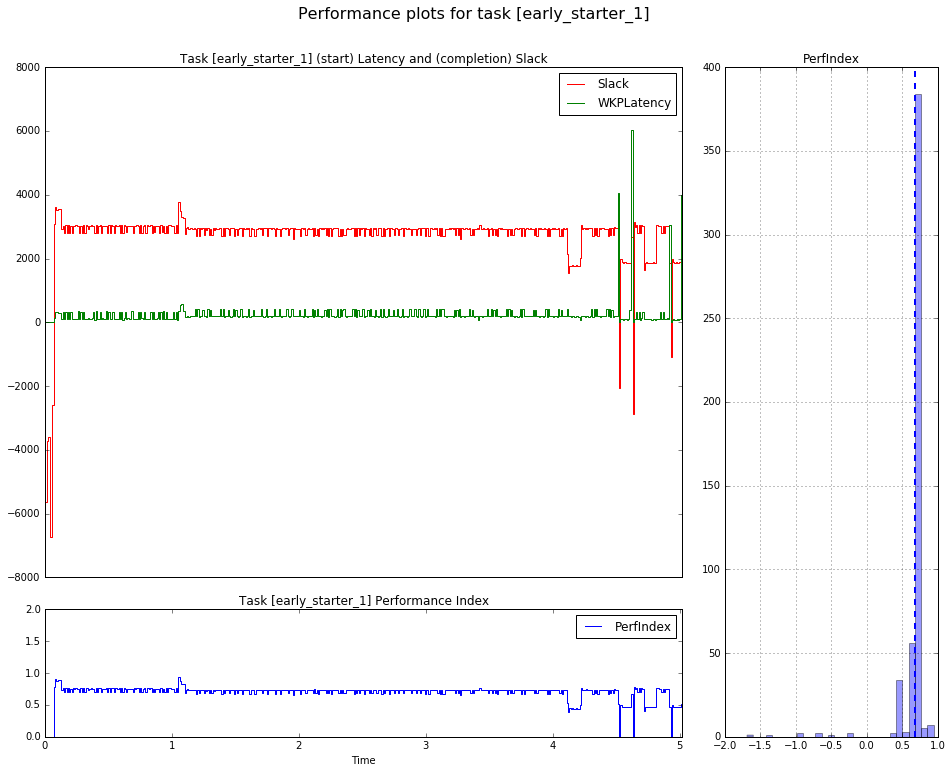

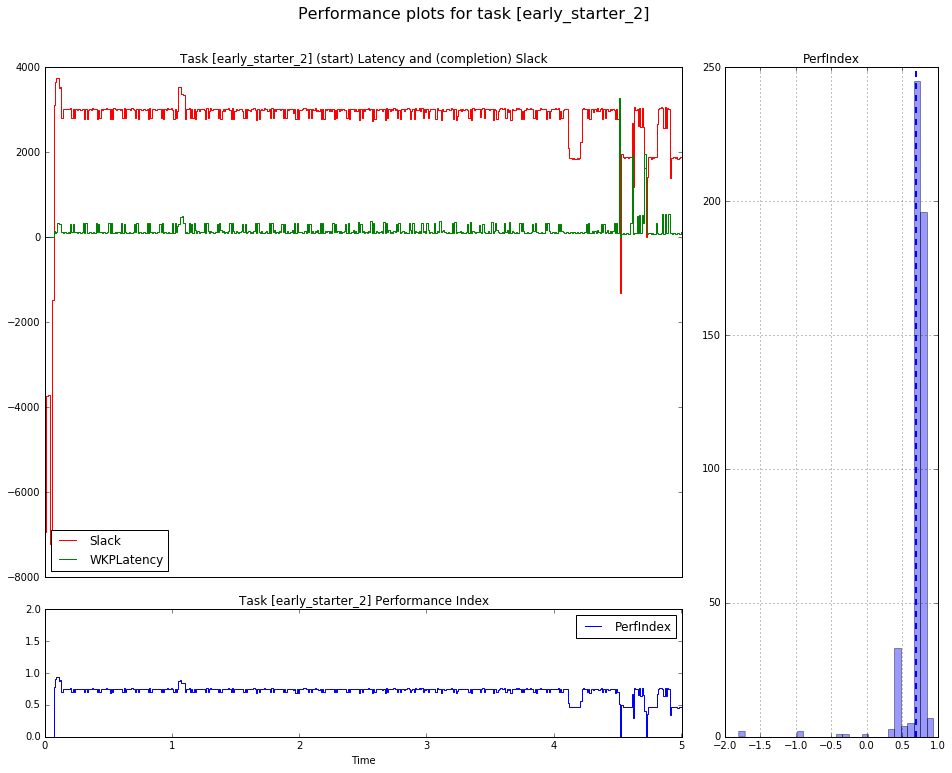

In [38]:
# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

# Trace Overview

In [16]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(ftrace)

In [17]:
# Add column with util_max = max(util_avg, util_est)
df = ftrace.sched_load_avg_cpu.data_frame

#print df[['util_avg', 'util_est']]
#print df[['util_avg']]

#df['util_max'] = df[['util_avg', 'util_est']].max(axis=1)

df['util_max'] = df[['util_avg']].max(axis=1)

# Task Utilization

# CPU Utilization

In [19]:
trappy.ILinePlot(
    ftrace,
    signals=[
      'sched_load_avg_cpu:util_avg',
      'sched_load_avg_cpu:util_max',
    ],
    pivot='cpu',
    filters={'cpu': [0,1,2,3,4, 5,6,7]},
    drawstyle='steps-post',
    scatter=False,
#     sync_zoom=True,
#     group='PeriodicAndRamp',
    marker = '+').view()

,
,
,
,
,
,
,
,
